**Chapter 10 – Introduction to Artificial Neural Networks**

_This notebook contains all the sample code and solutions to the exercises in chapter 10._

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Perceptrons

In [2]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)]  # petal length, petal width
y = (iris.target == 0).astype(np.int)

per_clf = Perceptron(max_iter=100, random_state=42)
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])

In [3]:
y_pred

array([1])

Saving figure perceptron_iris_plot


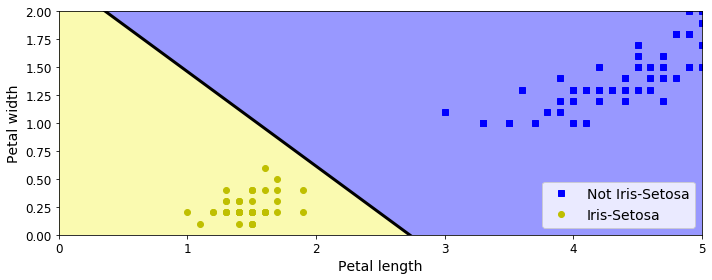

In [4]:
a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]

axes = [0, 5, 0, 2]

x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)

save_fig("perceptron_iris_plot")
plt.show()

# Activation functions

In [5]:
def logit(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

Saving figure activation_functions_plot


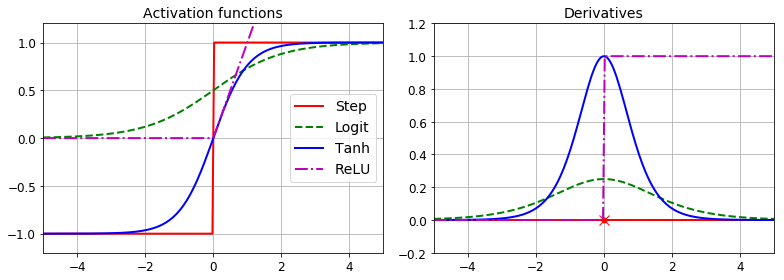

In [6]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=2, label="Step")
plt.plot(z, logit(z), "g--", linewidth=2, label="Logit")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=2, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(logit, z), "g--", linewidth=2, label="Logit")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("activation_functions_plot")
plt.show()

In [7]:
def heaviside(z):
    return (z >= 0).astype(z.dtype)

def sigmoid(z):
    return 1/(1+np.exp(-z))

def mlp_xor(x1, x2, activation=heaviside):
    return activation(-activation(x1 + x2 - 1.5) + activation(x1 + x2 - 0.5) - 0.5)

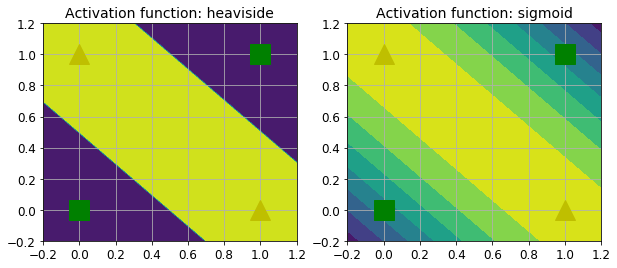

In [8]:
x1s = np.linspace(-0.2, 1.2, 100)
x2s = np.linspace(-0.2, 1.2, 100)
x1, x2 = np.meshgrid(x1s, x2s)

z1 = mlp_xor(x1, x2, activation=heaviside)
z2 = mlp_xor(x1, x2, activation=sigmoid)

plt.figure(figsize=(10,4))

plt.subplot(121)
plt.contourf(x1, x2, z1)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: heaviside", fontsize=14)
plt.grid(True)

plt.subplot(122)
plt.contourf(x1, x2, z2)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: sigmoid", fontsize=14)
plt.grid(True)

# FNN for MNIST

## Using the Estimator API (formerly `tf.contrib.learn`)

In [9]:
import tensorflow as tf

**Warning**: `tf.examples.tutorials.mnist` is deprecated. We will use `tf.keras.datasets.mnist` instead. Moreover, the `tf.contrib.learn` API was promoted to `tf.estimators` and `tf.feature_columns`, and it has changed considerably. In particular, there is no `infer_real_valued_columns_from_input()` function or `SKCompat` class.

In [10]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [11]:
feature_cols = [tf.feature_column.numeric_column("X", shape=[28 * 28])]
dnn_clf = tf.estimator.DNNClassifier(hidden_units=[300,100], n_classes=10,
                                     feature_columns=feature_cols)

input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"X": X_train}, y=y_train, num_epochs=40, batch_size=50, shuffle=True)
dnn_clf.train(input_fn=input_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_evaluation_master': '', '_session_config': None, '_model_dir': '/tmp/tmpuflzeb_h', '_task_type': 'worker', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f4fcb4e15c0>, '_save_summary_steps': 100, '_is_chief': True, '_save_checkpoints_steps': None, '_log_step_count_steps': 100, '_master': '', '_service': None, '_keep_checkpoint_every_n_hours': 10000, '_task_id': 0, '_tf_random_seed': None, '_num_ps_replicas': 0, '_global_id_in_cluster': 0, '_train_distribute': None, '_num_worker_replicas': 1, '_save_checkpoints_secs': 600, '_keep_checkpoint_max': 5}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpuflzeb_h/model.ckpt.
INFO:tensorflow:loss = 122.8

INFO:tensorflow:global_step/sec: 754.457
INFO:tensorflow:loss = 0.02294194, step = 7300 (0.132 sec)
INFO:tensorflow:global_step/sec: 665.539
INFO:tensorflow:loss = 0.03988394, step = 7400 (0.151 sec)
INFO:tensorflow:global_step/sec: 664.489
INFO:tensorflow:loss = 0.35611078, step = 7500 (0.150 sec)
INFO:tensorflow:global_step/sec: 642.162
INFO:tensorflow:loss = 0.37163323, step = 7600 (0.156 sec)
INFO:tensorflow:global_step/sec: 710.797
INFO:tensorflow:loss = 0.2848217, step = 7700 (0.141 sec)
INFO:tensorflow:global_step/sec: 761.344
INFO:tensorflow:loss = 0.7845428, step = 7800 (0.131 sec)
INFO:tensorflow:global_step/sec: 765.77
INFO:tensorflow:loss = 0.10574758, step = 7900 (0.130 sec)
INFO:tensorflow:global_step/sec: 723.478
INFO:tensorflow:loss = 0.69526076, step = 8000 (0.138 sec)
INFO:tensorflow:global_step/sec: 750.877
INFO:tensorflow:loss = 0.58130324, step = 8100 (0.133 sec)
INFO:tensorflow:global_step/sec: 730.965
INFO:tensorflow:loss = 0.31362545, step = 8200 (0.137 sec)
INF

INFO:tensorflow:global_step/sec: 760.143
INFO:tensorflow:loss = 0.19096217, step = 15500 (0.131 sec)
INFO:tensorflow:global_step/sec: 729.355
INFO:tensorflow:loss = 0.07447162, step = 15600 (0.137 sec)
INFO:tensorflow:global_step/sec: 721.879
INFO:tensorflow:loss = 0.008595724, step = 15700 (0.138 sec)
INFO:tensorflow:global_step/sec: 725.15
INFO:tensorflow:loss = 0.02350374, step = 15800 (0.138 sec)
INFO:tensorflow:global_step/sec: 750.054
INFO:tensorflow:loss = 0.23393407, step = 15900 (0.135 sec)
INFO:tensorflow:global_step/sec: 686.044
INFO:tensorflow:loss = 0.052663296, step = 16000 (0.145 sec)
INFO:tensorflow:global_step/sec: 571.582
INFO:tensorflow:loss = 0.07737052, step = 16100 (0.175 sec)
INFO:tensorflow:global_step/sec: 621.862
INFO:tensorflow:loss = 0.059392054, step = 16200 (0.161 sec)
INFO:tensorflow:global_step/sec: 680.005
INFO:tensorflow:loss = 0.112042084, step = 16300 (0.147 sec)
INFO:tensorflow:global_step/sec: 733.16
INFO:tensorflow:loss = 0.019262556, step = 16400

INFO:tensorflow:global_step/sec: 720.016
INFO:tensorflow:loss = 0.05611958, step = 23600 (0.139 sec)
INFO:tensorflow:global_step/sec: 670.816
INFO:tensorflow:loss = 0.040629435, step = 23700 (0.149 sec)
INFO:tensorflow:global_step/sec: 679.358
INFO:tensorflow:loss = 0.039468687, step = 23800 (0.147 sec)
INFO:tensorflow:global_step/sec: 591.633
INFO:tensorflow:loss = 0.07725768, step = 23900 (0.169 sec)
INFO:tensorflow:global_step/sec: 626.386
INFO:tensorflow:loss = 0.07133426, step = 24000 (0.160 sec)
INFO:tensorflow:global_step/sec: 622.443
INFO:tensorflow:loss = 0.01620267, step = 24100 (0.160 sec)
INFO:tensorflow:global_step/sec: 757.569
INFO:tensorflow:loss = 0.033674255, step = 24200 (0.132 sec)
INFO:tensorflow:global_step/sec: 759.175
INFO:tensorflow:loss = 0.02904886, step = 24300 (0.132 sec)
INFO:tensorflow:global_step/sec: 643.196
INFO:tensorflow:loss = 0.021125063, step = 24400 (0.156 sec)
INFO:tensorflow:global_step/sec: 764.936
INFO:tensorflow:loss = 0.010064006, step = 245

INFO:tensorflow:global_step/sec: 724.457
INFO:tensorflow:loss = 0.011149004, step = 31700 (0.138 sec)
INFO:tensorflow:global_step/sec: 749.343
INFO:tensorflow:loss = 0.011274818, step = 31800 (0.134 sec)
INFO:tensorflow:global_step/sec: 717.722
INFO:tensorflow:loss = 0.016880032, step = 31900 (0.139 sec)
INFO:tensorflow:global_step/sec: 686.074
INFO:tensorflow:loss = 0.034965005, step = 32000 (0.146 sec)
INFO:tensorflow:global_step/sec: 747.228
INFO:tensorflow:loss = 0.0711512, step = 32100 (0.134 sec)
INFO:tensorflow:global_step/sec: 758.061
INFO:tensorflow:loss = 0.020935431, step = 32200 (0.132 sec)
INFO:tensorflow:global_step/sec: 754.156
INFO:tensorflow:loss = 0.05625681, step = 32300 (0.133 sec)
INFO:tensorflow:global_step/sec: 752.545
INFO:tensorflow:loss = 0.008945845, step = 32400 (0.133 sec)
INFO:tensorflow:global_step/sec: 774.541
INFO:tensorflow:loss = 0.0025368293, step = 32500 (0.129 sec)
INFO:tensorflow:global_step/sec: 778.982
INFO:tensorflow:loss = 0.025532966, step = 

INFO:tensorflow:global_step/sec: 731.693
INFO:tensorflow:loss = 0.034165256, step = 39800 (0.137 sec)
INFO:tensorflow:global_step/sec: 712.66
INFO:tensorflow:loss = 0.018817844, step = 39900 (0.140 sec)
INFO:tensorflow:global_step/sec: 767.888
INFO:tensorflow:loss = 0.064586915, step = 40000 (0.130 sec)
INFO:tensorflow:global_step/sec: 682.678
INFO:tensorflow:loss = 0.039944634, step = 40100 (0.147 sec)
INFO:tensorflow:global_step/sec: 637.928
INFO:tensorflow:loss = 0.006592812, step = 40200 (0.158 sec)
INFO:tensorflow:global_step/sec: 654.42
INFO:tensorflow:loss = 0.0012000705, step = 40300 (0.152 sec)
INFO:tensorflow:global_step/sec: 735.869
INFO:tensorflow:loss = 0.0021813547, step = 40400 (0.136 sec)
INFO:tensorflow:global_step/sec: 739.684
INFO:tensorflow:loss = 0.020016534, step = 40500 (0.135 sec)
INFO:tensorflow:global_step/sec: 722.897
INFO:tensorflow:loss = 0.010720066, step = 40600 (0.138 sec)
INFO:tensorflow:global_step/sec: 750.822
INFO:tensorflow:loss = 0.05658368, step =

In [12]:
test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"X": X_test}, y=y_test, shuffle=False)
eval_results = dnn_clf.evaluate(input_fn=test_input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-18-19:12:49
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpuflzeb_h/model.ckpt-44000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-18-19:12:50
INFO:tensorflow:Saving dict for global step 44000: accuracy = 0.9798, average_loss = 0.10096103, global_step = 44000, loss = 12.779877


In [13]:
eval_results

{'accuracy': 0.9798,
 'average_loss': 0.10096103,
 'global_step': 44000,
 'loss': 12.779877}

In [14]:
y_pred_iter = dnn_clf.predict(input_fn=test_input_fn)
y_pred = list(y_pred_iter)
y_pred[0]

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpuflzeb_h/model.ckpt-44000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


{'class_ids': array([7]),
 'classes': array([b'7'], dtype=object),
 'logits': array([ -3.809414 ,  -4.1564407,  -0.426081 ,   3.2636993, -11.065331 ,
         -8.790985 , -10.436305 ,  19.935707 ,  -6.9282775,   2.2807484],
       dtype=float32),
 'probabilities': array([4.8710768e-11, 3.4428106e-11, 1.4354495e-09, 5.7469666e-08,
        3.4389070e-14, 3.3431518e-13, 6.4506329e-14, 1.0000000e+00,
        2.1533745e-12, 2.1505466e-08], dtype=float32)}

## Using plain TensorFlow

In [15]:
import tensorflow as tf

n_inputs = 28*28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [16]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [17]:
def neuron_layer(X, n_neurons, name, activation=None):
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        W = tf.Variable(init, name="kernel")
        b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        Z = tf.matmul(X, W) + b
        if activation is not None:
            return activation(Z)
        else:
            return Z

In [18]:
with tf.name_scope("dnn"):
    hidden1 = neuron_layer(X, n_hidden1, name="hidden1",
                           activation=tf.nn.relu)
    hidden2 = neuron_layer(hidden1, n_hidden2, name="hidden2",
                           activation=tf.nn.relu)
    logits = neuron_layer(hidden2, n_outputs, name="outputs")

In [19]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                              logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [20]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [21]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [22]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [23]:
n_epochs = 40
batch_size = 50

In [24]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [25]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Batch accuracy:", acc_batch, "Val accuracy:", acc_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Batch accuracy: 0.9 Val accuracy: 0.9146
1 Batch accuracy: 0.92 Val accuracy: 0.936
2 Batch accuracy: 0.96 Val accuracy: 0.945
3 Batch accuracy: 0.92 Val accuracy: 0.9512
4 Batch accuracy: 0.98 Val accuracy: 0.9558
5 Batch accuracy: 0.96 Val accuracy: 0.9566
6 Batch accuracy: 1.0 Val accuracy: 0.9612
7 Batch accuracy: 0.94 Val accuracy: 0.963
8 Batch accuracy: 0.98 Val accuracy: 0.9652
9 Batch accuracy: 0.96 Val accuracy: 0.966
10 Batch accuracy: 0.92 Val accuracy: 0.9688
11 Batch accuracy: 0.98 Val accuracy: 0.969
12 Batch accuracy: 0.98 Val accuracy: 0.967
13 Batch accuracy: 0.98 Val accuracy: 0.9706
14 Batch accuracy: 1.0 Val accuracy: 0.9714
15 Batch accuracy: 0.94 Val accuracy: 0.9732
16 Batch accuracy: 1.0 Val accuracy: 0.9736
17 Batch accuracy: 1.0 Val accuracy: 0.9742
18 Batch accuracy: 1.0 Val accuracy: 0.9746
19 Batch accuracy: 0.98 Val accuracy: 0.9748
20 Batch accuracy: 1.0 Val accuracy: 0.9752
21 Batch accuracy: 1.0 Val accuracy: 0.9752
22 Batch accuracy: 0.98 Val accura

In [26]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt") # or better, use save_path
    X_new_scaled = X_test[:20]
    Z = logits.eval(feed_dict={X: X_new_scaled})
    y_pred = np.argmax(Z, axis=1)

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt


In [27]:
print("Predicted classes:", y_pred)
print("Actual classes:   ", y_test[:20])

Predicted classes: [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]
Actual classes:    [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]


In [28]:
from tensorflow_graph_in_jupyter import show_graph

In [29]:
show_graph(tf.get_default_graph())

## Using `dense()` instead of `neuron_layer()`

Note: previous releases of the book used `tensorflow.contrib.layers.fully_connected()` rather than `tf.layers.dense()` (which did not exist when this chapter was written). It is now preferable to use `tf.layers.dense()`, because anything in the contrib module may change or be deleted without notice. The `dense()` function is almost identical to the `fully_connected()` function, except for a few minor differences:
* several parameters are renamed: `scope` becomes `name`, `activation_fn` becomes `activation` (and similarly the `_fn` suffix is removed from other parameters such as `normalizer_fn`), `weights_initializer` becomes `kernel_initializer`, etc.
* the default `activation` is now `None` rather than `tf.nn.relu`.
* a few more differences are presented in chapter 11.

In [30]:
n_inputs = 28*28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [31]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y") 

In [32]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1",
                              activation=tf.nn.relu)
    hidden2 = tf.layers.dense(hidden1, n_hidden2, name="hidden2",
                              activation=tf.nn.relu)
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")
    y_proba = tf.nn.softmax(logits)

In [33]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [34]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [35]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [36]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [37]:
n_epochs = 20
n_batches = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Batch accuracy: 0.9 Validation accuracy: 0.9024
1 Batch accuracy: 0.92 Validation accuracy: 0.9254
2 Batch accuracy: 0.94 Validation accuracy: 0.9372
3 Batch accuracy: 0.9 Validation accuracy: 0.9416
4 Batch accuracy: 0.94 Validation accuracy: 0.9472
5 Batch accuracy: 0.94 Validation accuracy: 0.9512
6 Batch accuracy: 1.0 Validation accuracy: 0.9548
7 Batch accuracy: 0.94 Validation accuracy: 0.961
8 Batch accuracy: 0.96 Validation accuracy: 0.962
9 Batch accuracy: 0.94 Validation accuracy: 0.9648
10 Batch accuracy: 0.92 Validation accuracy: 0.9656
11 Batch accuracy: 0.98 Validation accuracy: 0.9668
12 Batch accuracy: 0.98 Validation accuracy: 0.9684
13 Batch accuracy: 0.98 Validation accuracy: 0.9702
14 Batch accuracy: 1.0 Validation accuracy: 0.9696
15 Batch accuracy: 0.94 Validation accuracy: 0.9718
16 Batch accuracy: 0.98 Validation accuracy: 0.9728
17 Batch accuracy: 1.0 Validation accuracy: 0.973
18 Batch accuracy: 0.98 Validation accuracy: 0.9748
19 Batch accuracy: 0.98 Valida

In [38]:
show_graph(tf.get_default_graph())

# Exercise solutions

## 1. to 8.

See appendix A.

## 9.

_Train a deep MLP on the MNIST dataset and see if you can get over 98% precision. Just like in the last exercise of chapter 9, try adding all the bells and whistles (i.e., save checkpoints, restore the last checkpoint in case of an interruption, add summaries, plot learning curves using TensorBoard, and so on)._

First let's create the deep net. It's exactly the same as earlier, with just one addition: we add a `tf.summary.scalar()` to track the loss and the accuracy during training, so we can view nice learning curves using TensorBoard.

In [40]:
n_inputs = 28*28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [41]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y") 

In [42]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1",
                              activation=tf.nn.relu)
    hidden2 = tf.layers.dense(hidden1, n_hidden2, name="hidden2",
                              activation=tf.nn.relu)
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [43]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    loss_summary = tf.summary.scalar('log_loss', loss)

In [44]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [45]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    accuracy_summary = tf.summary.scalar('accuracy', accuracy)

In [46]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

Now we need to define the directory to write the TensorBoard logs to:

In [47]:
from datetime import datetime

def log_dir(prefix=""):
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = "tf_logs"
    if prefix:
        prefix += "-"
    name = prefix + "run-" + now
    return "{}/{}/".format(root_logdir, name)

In [48]:
logdir = log_dir("mnist_dnn")

Now we can create the `FileWriter` that we will use to write the TensorBoard logs:

In [49]:
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

Hey! Why don't we implement early stopping? For this, we are going to need to use the validation set.

In [50]:
m, n = X_train.shape

In [52]:
n_epochs = 10001
batch_size = 50
n_batches = int(np.ceil(m / batch_size))

checkpoint_path = "/tmp/my_deep_mnist_model.ckpt"
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = "./my_deep_mnist_model"

best_loss = np.infty
epochs_without_progress = 0
max_epochs_without_progress = 50

with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        # if the checkpoint file exists, restore the model and load the epoch number
        with open(checkpoint_epoch_path, "rb") as f:
            start_epoch = int(f.read())
        print("Training was interrupted. Continuing at epoch", start_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        start_epoch = 0
        sess.run(init)

    for epoch in range(start_epoch, n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val, loss_val, accuracy_summary_str, loss_summary_str = sess.run([accuracy, loss, accuracy_summary, loss_summary], feed_dict={X: X_valid, y: y_valid})
        file_writer.add_summary(accuracy_summary_str, epoch)
        file_writer.add_summary(loss_summary_str, epoch)
        if epoch % 5 == 0:
            print("Epoch:", epoch,
                  "\tValidation accuracy: {:.3f}%".format(accuracy_val * 100),
                  "\tLoss: {:.5f}".format(loss_val))
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch + 1))
            if loss_val < best_loss:
                saver.save(sess, final_model_path)
                best_loss = loss_val
            else:
                epochs_without_progress += 5
                if epochs_without_progress > max_epochs_without_progress:
                    print("Early stopping")
                    break

Epoch: 0 	Validation accuracy: 92.180% 	Loss: 0.30208
Epoch: 5 	Validation accuracy: 95.980% 	Loss: 0.15037
Epoch: 10 	Validation accuracy: 97.100% 	Loss: 0.11160
Epoch: 15 	Validation accuracy: 97.700% 	Loss: 0.09562
Epoch: 20 	Validation accuracy: 97.840% 	Loss: 0.08309
Epoch: 25 	Validation accuracy: 98.040% 	Loss: 0.07706
Epoch: 30 	Validation accuracy: 98.140% 	Loss: 0.07287
Epoch: 35 	Validation accuracy: 98.280% 	Loss: 0.07133
Epoch: 40 	Validation accuracy: 98.220% 	Loss: 0.06968
Epoch: 45 	Validation accuracy: 98.220% 	Loss: 0.06993
Epoch: 50 	Validation accuracy: 98.160% 	Loss: 0.07093
Epoch: 55 	Validation accuracy: 98.280% 	Loss: 0.06994
Epoch: 60 	Validation accuracy: 98.200% 	Loss: 0.06894
Epoch: 65 	Validation accuracy: 98.260% 	Loss: 0.06906
Epoch: 70 	Validation accuracy: 98.220% 	Loss: 0.07057
Epoch: 75 	Validation accuracy: 98.280% 	Loss: 0.06963
Epoch: 80 	Validation accuracy: 98.320% 	Loss: 0.07264
Epoch: 85 	Validation accuracy: 98.200% 	Loss: 0.07403
Epoch: 90 	V

In [53]:
os.remove(checkpoint_epoch_path)

In [54]:
with tf.Session() as sess:
    saver.restore(sess, final_model_path)
    accuracy_val = accuracy.eval(feed_dict={X: X_test, y: y_test})

INFO:tensorflow:Restoring parameters from ./my_deep_mnist_model


In [55]:
accuracy_val

0.9796